In this section you will do a practical application of GPU-accelerated data analysis using the RAPIDS
suite of libraries. The focus will be on leveraging the New York City Taxi Trip Duration dataset from
Kaggle, applying Gradient Boosting Machine (GBM) models for predictive analysis, with a particular
emphasis on comparing the speed and efficiency of GPU-accelerated computations with traditional CPUbased methods 

1. Comparative Data Processing
(a)  Perform data loading and preprocessing tasks first using pandas (CPU) and then replicate the
same tasks using cuDF (GPU). Document the time taken for each operation in both scenarios.
(b)  Conduct basic exploratory data analysis (EDA) with both CPU-based tools (e.g., matplotlib)
and GPU-accelerated tools, noting any differences in performance and responsiveness.
2. Feature Engineering and Selection
(a) Engage in feature engineering, creating new variables that could aid in predicting trip durations. Compare the execution time for these operations on CPU vs. GPU.
(b) Select relevant features for the model based on their correlation with the target variable,
assessing the speed of these operations on CPU and GPU.
3. Model Training and Evaluation
(a) Train a Gradient Boosting Machine (GBM) model on the dataset using scikit-learn (CPU)
and cuML (GPU). Record and compare the training times.
(b) Evaluate the accuracy of both models and document the time taken for predictions on the
test set using CPU and GPU.
4. Performance Analysis
(a) Compile and compare the execution times for tasks performed on CPU vs. GPU, creating a
detailed analysis of the observed performance differences.
(b) Reflect on the implications of these findings for data science workflows, particularly in terms
of efficiency and scalability.

# (a) Perform data loading and preprocessing tasks first using pandas (CPU) and then replicate the same tasks using cuDF (GPU). Document the time taken for each operation in both scenarios.

In [1]:
# !pip install pandas==2.1.4
#!pip install matplotlib
#!pip install hvplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.1 MB/s eta 0:00:0000:0100:01


In [2]:
# !pip install \
#     --extra-index-url=https://pypi.nvidia.com \
#     cudf-cu12==24.2.* dask-cudf-cu12==24.2.* cuml-cu12==24.2.* \
#     cugraph-cu12==24.2.* cuspatial-cu12==24.2.* cuproj-cu12==24.2.* \
#     cuxfilter-cu12==24.2.* cucim-cu12==24.2.* pylibraft-cu12==24.2.* \
#     raft-dask-cu12==24.2.*

In [4]:
# Importing necessary libraries
import pandas as pd
import cudf
import cupy as cp

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
# ignore warnings
import hvplot.pandas
import warnings
warnings.filterwarnings("ignore")

## Loading the Datasts

In [5]:
# create a dataframe to hold CPU Metrics
cpu_metrics = pd.DataFrame(columns=['Task', 'start_time', 'end_time', 'time_taken'])

# create a dataframe to hold GPU Metrics
gpu_metrics = pd.DataFrame(columns=['Task', 'start_time', 'end_time', 'time_taken'])

In [7]:
# Load the data using cuDF
start_time_gpu = time.time()
sample_submission_gpu = cudf.read_csv('/kaggle/input/taxi-datasets/sample_submission.csv')
test_gpu = cudf.read_csv('/kaggle/input/taxi-datasets/test.csv')
train_gpu = cudf.read_csv('/kaggle/input/taxi-datasets/train.csv')
end_time_gpu = time.time()

In [8]:
# Load the data using pandas
start_time_cpu = time.time()
sample_submission_cpu = pd.read_csv('/kaggle/input/taxi-datasets/sample_submission.csv')
test_cpu = pd.read_csv('/kaggle/input/taxi-datasets/test.csv')
train_cpu = pd.read_csv('/kaggle/input/taxi-datasets/train.csv')
end_time_cpu = time.time()

In [9]:
# Display the time taken for data loading using pandas
print("Time taken for data loading using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for data loading using cuDF
print("Time taken for data loading using GUP: ", end_time_gpu - start_time_gpu)

Time taken for data loading using pandas:  6.06785774230957
Time taken for data loading using GUP:  0.26885557174682617


In [10]:
# Add the metrics to the dataframe
cpu_metrics.loc[0] = ['Data Loading', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[0] = ['Data Loading', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

In [11]:
sample_submission_cpu.head(5)

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


In [12]:
test_cpu.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [13]:
train_cpu.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## Data Preprocessing


In [14]:
# Data Preprocessing using cuDF
time_start_gpu = time.time()
# drop rows with missing values
train_gpu.dropna(inplace=True)
test_gpu.dropna(inplace=True)

# drop records with duplicated IDs
train_gpu.drop_duplicates(subset='id', inplace=True)

# convert the 'pickup_datetime' and 'dropoff_datetime' columns to datetime format
train_gpu['pickup_datetime'] = cudf.to_datetime(train_gpu['pickup_datetime'])

# drop the 'dropoff_datetime' column since it is not available in the test set and is not needed for prediction
# the trip duration is calculated as the difference between the 'dropoff_datetime' and 'pickup_datetime'
train_gpu.drop('dropoff_datetime', axis=1, inplace=True)

test_gpu['pickup_datetime'] = cudf.to_datetime(test_gpu['pickup_datetime'])

# create new columns for the pickup month, day of the week, and hour of the day
train_gpu['pickup_month'] = train_gpu['pickup_datetime'].dt.month
train_gpu['pickup_day'] = train_gpu['pickup_datetime'].dt.dayofweek
train_gpu['pickup_hour'] = train_gpu['pickup_datetime'].dt.hour

test_gpu['pickup_month'] = test_gpu['pickup_datetime'].dt.month
test_gpu['pickup_day'] = test_gpu['pickup_datetime'].dt.dayofweek
test_gpu['pickup_hour'] = test_gpu['pickup_datetime'].dt.hour

end_time_gpu = time.time()

In [15]:
# Data Preprocessing using pandas
time_start_cpu = time.time()
# drop rows with missing values
train_cpu.dropna(inplace=True)
test_cpu.dropna(inplace=True)

# drop records with duplicated IDs
train_cpu.drop_duplicates(subset='id', inplace=True)

# convert the 'pickup_datetime' and 'dropoff_datetime' columns to datetime format
train_cpu['pickup_datetime'] = pd.to_datetime(train_cpu['pickup_datetime'])

# drop the 'dropoff_datetime' column since it is not available in the test set and is not needed for prediction
# the trip duration is calculated as the difference between the 'dropoff_datetime' and 'pickup_datetime'
train_cpu.drop('dropoff_datetime', axis=1, inplace=True)

test_cpu['pickup_datetime'] = pd.to_datetime(test_cpu['pickup_datetime'])

# create new columns for the pickup month, day of the week, and hour of the day
train_cpu['pickup_month'] = train_cpu['pickup_datetime'].dt.month
train_cpu['pickup_day'] = train_cpu['pickup_datetime'].dt.dayofweek
train_cpu['pickup_hour'] = train_cpu['pickup_datetime'].dt.hour

test_cpu['pickup_month'] = test_cpu['pickup_datetime'].dt.month
test_cpu['pickup_day'] = test_cpu['pickup_datetime'].dt.dayofweek
test_cpu['pickup_hour'] = test_cpu['pickup_datetime'].dt.hour

end_time_cpu = time.time()

In [16]:
# Display the time taken for data preprocessing using pandas
print("Time taken for data preprocessing using pandas: ", end_time_cpu - time_start_cpu)
# Display the time taken for data preprocessing using cuDF
print("Time taken for data preprocessing using GUP: ", end_time_gpu - time_start_gpu)

Time taken for data preprocessing using pandas:  2.3131580352783203
Time taken for data preprocessing using GUP:  0.2533383369445801


In [17]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Data Preprocessing', time_start_cpu, end_time_cpu, end_time_cpu - time_start_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Data Preprocessing', time_start_gpu, end_time_gpu, end_time_gpu - time_start_gpu]

In [18]:
# make the trip duration the last column in the train dataset
train_gpu = train_gpu[[col for col in train_gpu.columns if col != 'trip_duration'] + ['trip_duration']]
train_cpu = train_cpu[[col for col in train_cpu.columns if col != 'trip_duration'] + ['trip_duration']]

In [19]:
train_cpu.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_day,pickup_hour,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,3,0,17,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6,6,0,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,1,1,11,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,4,2,19,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,3,5,13,435


In [20]:
test_cpu.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_day,pickup_hour
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,6,3,23
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,6,3,23
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,6,3,23
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,6,3,23
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,6,3,23


In [21]:
train_gpu.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_day,pickup_hour,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,3,0,17,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6,6,0,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,1,1,11,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,4,2,19,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,3,5,13,435


In [22]:
test_gpu.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_month,pickup_day,pickup_hour
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,6,3,23
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,6,3,23
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,6,3,23
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,6,3,23
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,6,3,23


## Outlier Analysis

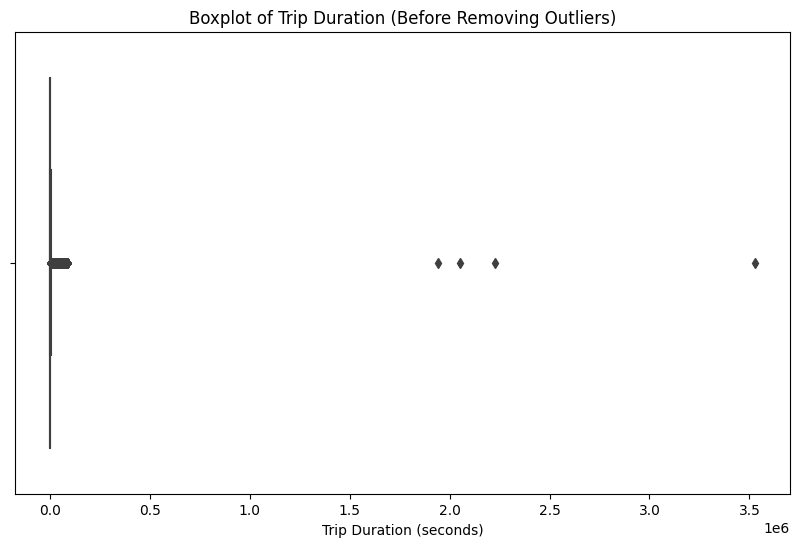


Interquartile Range (IQR): 678.0
Lower Bound: -620.0
Upper Bound: 2092.0
Number of Outliers: 74220 



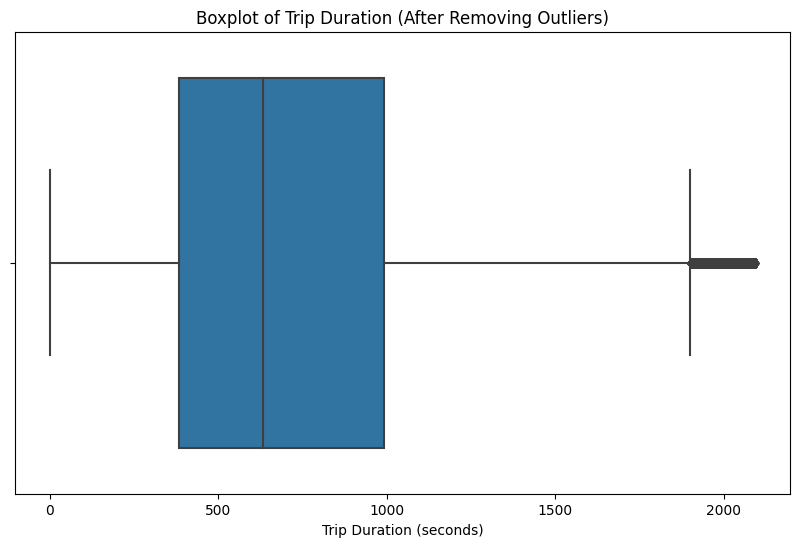

In [23]:
# using gpu
# plot boxplot for trip duration to identify outliers
# Convert GPU DataFrame to NumPy array
start_time_gpu = time.time()

train_gpu_numpy = train_gpu['trip_duration'].to_numpy()

# Plot boxplot for trip duration
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_gpu_numpy)
plt.title('Boxplot of Trip Duration (Before Removing Outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.show()

# Calculate the interquartile range
Q1 = np.percentile(train_gpu_numpy, 25)
Q3 = np.percentile(train_gpu_numpy, 75)

IQR = Q3 - Q1

print('\nInterquartile Range (IQR):', IQR)

# Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

# Identify outliers
outliers = train_gpu_numpy[(train_gpu_numpy < lower_bound) | (train_gpu_numpy > upper_bound)]
print('Number of Outliers:', len(outliers), "\n")

# Remove outliers
train_gpu = train_gpu[(train_gpu['trip_duration'] >= lower_bound) & (train_gpu['trip_duration'] <= upper_bound)]

train_gpu_numpy2 = train_gpu['trip_duration'].to_numpy()
# boxplot after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_gpu_numpy2)
plt.title('Boxplot of Trip Duration (After Removing Outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.show()

end_time_gpu = time.time()

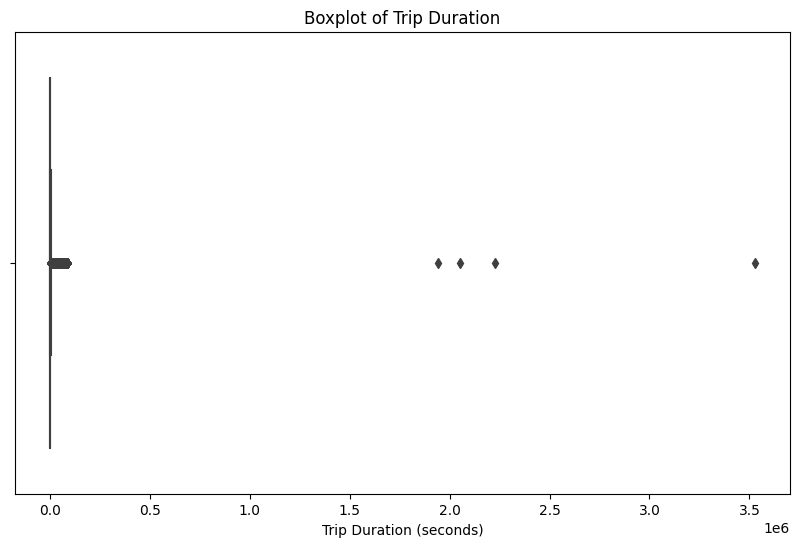


Interquartile Range (IQR): 678.0
Lower Bound: -620.0
Upper Bound: 2092.0
Number of Outliers: 74220 



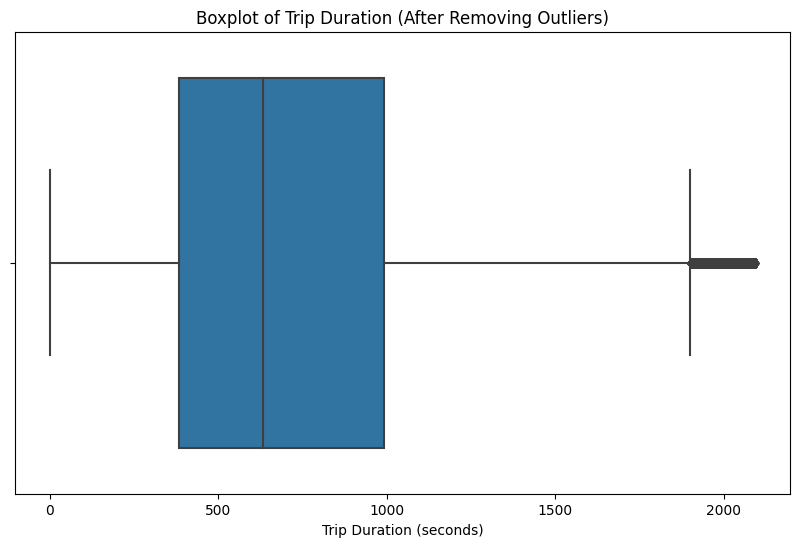

In [24]:
# using cpu
# plot boxplot for trip duration to identify outliers
# Plot boxplot for trip duration
start_time_cpu = time.time()

plt.figure(figsize=(10, 6))
sns.boxplot(x=train_cpu['trip_duration'])
plt.title('Boxplot of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.show()

# Calculate the interquartile range
Q1 = train_cpu['trip_duration'].quantile(0.25)
Q3 = train_cpu['trip_duration'].quantile(0.75)

IQR = Q3 - Q1

print('\nInterquartile Range (IQR):', IQR)

# Calculate the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

# Identify outliers
outliers = train_cpu[(train_cpu['trip_duration'] < lower_bound) | (train_cpu['trip_duration'] > upper_bound)]
print('Number of Outliers:', len(outliers), "\n")

# Remove outliers
train_cpu = train_cpu[(train_cpu['trip_duration'] >= lower_bound) & (train_cpu['trip_duration'] <= upper_bound)]

# boxplot after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_cpu['trip_duration'])
plt.title('Boxplot of Trip Duration (After Removing Outliers)')
plt.xlabel('Trip Duration (seconds)')
plt.show()

end_time_cpu = time.time()

In [25]:
# Display the time taken for outlier analysis using pandas
print("Time taken for outlier analysis using pandas: ", end_time_cpu - start_time_cpu)
# Display the time taken for outlier analysis using cuDF
print("Time taken for outlier analysis using GUP: ", end_time_gpu - start_time_gpu)

Time taken for outlier analysis using pandas:  1.031614065170288
Time taken for outlier analysis using GUP:  0.8942315578460693


In [26]:
# Add the metrics to the dataframe
cpu_metrics.loc[cpu_metrics.shape[0]] = ['Outlier Analysis', start_time_cpu, end_time_cpu, end_time_cpu - start_time_cpu]
gpu_metrics.loc[gpu_metrics.shape[0]] = ['Outlier Analysis', start_time_gpu, end_time_gpu, end_time_gpu - start_time_gpu]

# (b) Conduct basic exploratory data analysis (EDA) with both CPU-based tools (e.g., matplotlib) and GPU-accelerated tools, noting any differences in performance and responsiveness.


In [32]:
# Plot the distribution of trip durations and organize all plots in a single cell
(
    train_gpu['trip_duration'].to_pandas().hvplot.hist(
        title='Distribution of Trip Durations',
        bins=100,
        width=600,
        height=600,
        xlabel='Trip Duration (seconds)',
        ylabel='Frequency'
    ) +
    train_gpu.groupby('pickup_month')['trip_duration'].mean().to_pandas().hvplot.bar(
        title='Average Trip Duration by Month',
        width=600,
        height=600,
        xlabel='Month',
        ylabel='Average Trip Duration (seconds)'
    ) +
    train_gpu.groupby('pickup_day')['trip_duration'].mean().to_pandas().hvplot.bar(
        title='Average Trip Duration by Day of the Week',
        width=600,
        height=600,
        xlabel='Day of the Week',
        ylabel='Average Trip Duration (seconds)'
    ) +
    train_gpu.groupby('pickup_hour')['trip_duration'].mean().to_pandas().hvplot.bar(
        title='Average Trip Duration by Hour of the Day',
        width=600,
        height=600,
        xlabel='Hour of the Day',
        ylabel='Average Trip Duration (seconds)'
    ) +
    train_gpu.groupby('passenger_count')['trip_duration'].mean().to_pandas().hvplot.bar(
        title='Average Trip Duration by Passenger Count',
        width=600,
        height=600,
        xlabel='Passenger Count',
        ylabel='Average Trip Duration (seconds)'
    ) +
    train_gpu.to_pandas().hvplot.hexbin(
        x='pickup_longitude', 
        y='pickup_latitude', 
        width=600, 
        height=600, 
        geo=True, 
        tiles='OSM', 
        colorbar=True)
)


:Layout
   .Histogram.I            :Histogram   [trip_duration]   (trip_duration_count)
   .Bars.Trip_duration.I   :Bars   [pickup_month]   (trip_duration)
   .Bars.Trip_duration.II  :Bars   [pickup_day]   (trip_duration)
   .Bars.Trip_duration.III :Bars   [pickup_hour]   (trip_duration)
   .Bars.Trip_duration.IV  :Bars   [passenger_count]   (trip_duration)
   .Overlay.I              :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .HexTiles.I :HexTiles   [pickup_longitude,pickup_latitude]